In [20]:
import numpy as np
import scipy

import cupy as cp
import cupyx.scipy

import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output, display, HTML
display(HTML("<style>.container { width:90% !important; }</style>")) # just making the notebook cells wider

from importlib import reload
import time

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)

poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

import wfsc_tests as wfsc
wfsc.math_module.update_np(cp)
wfsc.math_module.update_scipy(cupyx.scipy)

from wfsc_tests.math_module import xp, _scipy

import cgi_phasec_poppy as cgi
reload(cgi)

from matplotlib.colors import ListedColormap
#Blue to Red Color scale for S1 and S2
colmap = np.zeros((255,3));
# Red
colmap[126:183,0]= np.linspace(0,1,57);
colmap[183:255,0]= 1;
# Green
colmap[0:96,1] = np.linspace(1,0,96);
colmap[158:255,1]= np.linspace(0,1,97);
# Blue
colmap[0:71,2] = 1;
colmap[71:128,2]= np.linspace(1,0,57);
colmap2 = colmap[128:,:]
colmap = ListedColormap(colmap)

# iefc_dir = Path('/groups/douglase/kians-data-files/roman-cgi-iefc-data')
iefc_dir = Path('/home/kianmilani/Projects/roman-cgi-iefc-data')

dm1_flat = 2*fits.getdata(cgi.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm1.fits')
dm2_flat = 2*fits.getdata(cgi.data_dir/'dm-acts'/'flatmaps'/'hlc_flattened_dm2.fits')

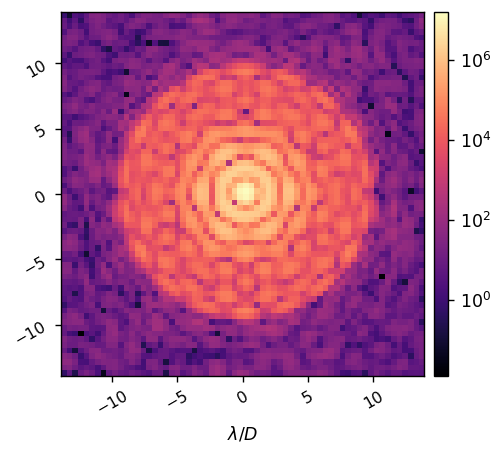

15167884.4713195

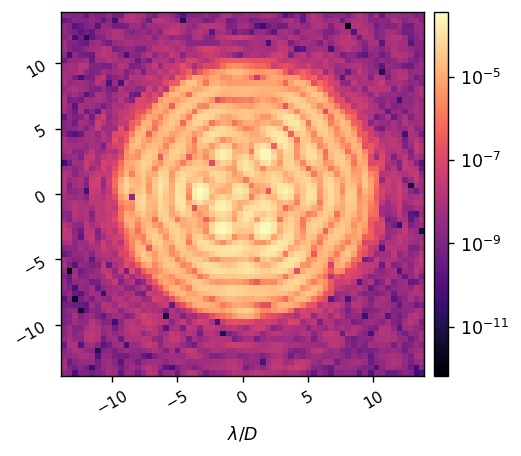

In [32]:
reload(cgi)

source_flux = 2.0208517e8 * u.ph/u.s/u.m**2 # flux of 47 UMa at 575nm with 10% bandpass

c = cgi.CGI(cgi_mode='hlc', 
              use_pupil_defocus=True, 
              use_opds=True,
              source_flux=source_flux,
            exp_time=5)

c.set_dm1(dm1_flat)
c.set_dm2(dm2_flat)

npsf = c.npsf
Nact = c.Nact

c.use_fpm = False
ref_unocc_im = c.snap()
wfsc.imshow1(ref_unocc_im, pxscl=c.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

max_ref = ref_unocc_im.get().max()
display(max_ref)

c.use_fpm = True
c.source_flux = source_flux/max_ref # divide the source flux to get nominal contrast images
ref_im = c.snap()
wfsc.imshow1(ref_im, pxscl=c.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True)

# Create dark hole ROI to calibrate and control

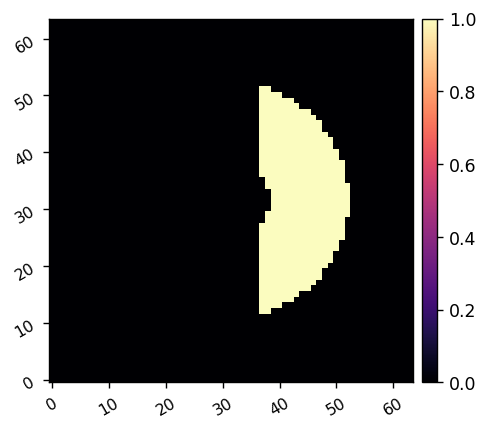

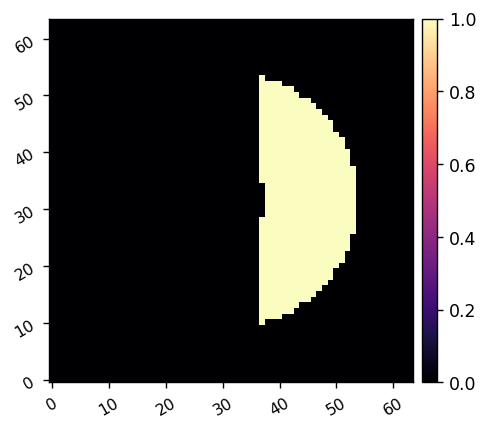

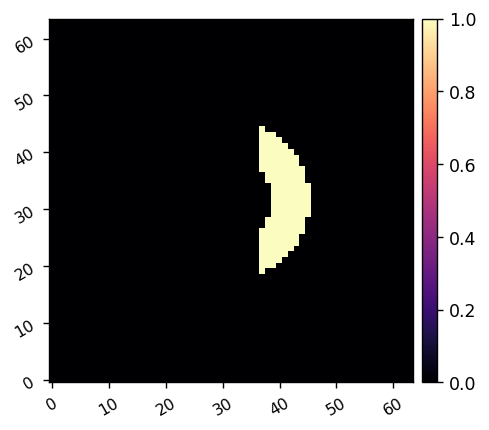

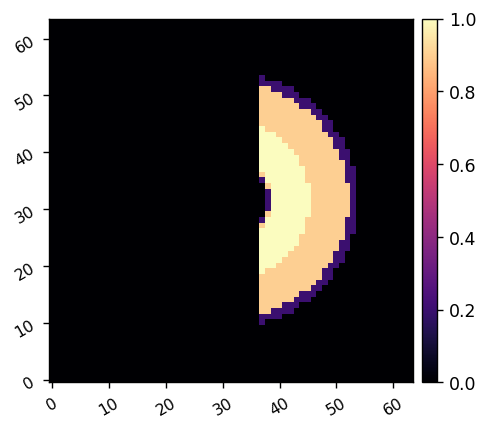

In [45]:
reload(wfsc)
reload(wfsc.utils)
reload(wfsc.imshows)
xfp = (xp.linspace(-npsf/2, npsf/2-1, npsf) + 1/2)*c.psf_pixelscale_lamD
fpx,fpy = xp.meshgrid(xfp,xfp)
  
iwa = 3
owa = 9
roi_params = {
        'inner_radius' : iwa,
        'outer_radius' : owa,
        'edge' : 2,
        'rotation':0,
        'full':True,
    }
roi1 = wfsc.utils.create_annular_focal_plane_mask(fpx, fpy, roi_params, plot=True)

iwa = 2.8
owa = 9.7
roi_params = {
        'inner_radius' : iwa,
        'outer_radius' : owa,
        'edge' : 2,
        'rotation':0,
        'full':True,
    }
roi2 = wfsc.utils.create_annular_focal_plane_mask(fpx, fpy, roi_params, plot=True)

iwa = 3.2
owa = 6
roi_params = {
        'inner_radius' : iwa,
        'outer_radius' : owa,
        'edge' : 2,
        'rotation':0,
        'full':True,
    }
roi3 = wfsc.utils.create_annular_focal_plane_mask(fpx, fpy, roi_params, plot=True)

relative_weight_1 = 0.9
relative_weight_2 = 0.2
weight_map = roi3 + relative_weight_1*(roi1*~roi3) + relative_weight_2*(roi2*~roi1*~roi3)
control_mask = weight_map>0
wfsc.imshow1(weight_map)

# Create probe and fourier modes

(236, 2304) (118, 2)


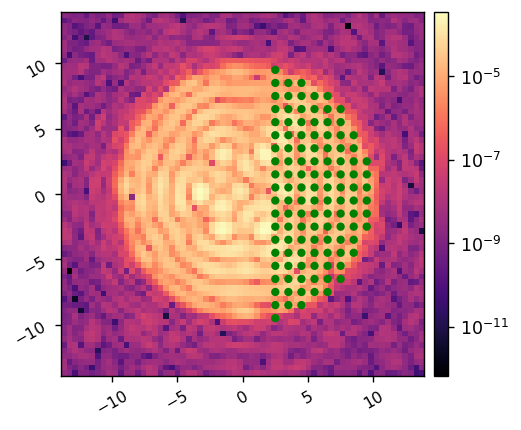

In [46]:
reload(wfsc.utils)
calib_amp = 5e-9
fourier_modes, fs = wfsc.utils.select_fourier_modes(c, control_mask*(fpx>0), fourier_sampling=1) 
nmodes = fourier_modes.shape[0]
nf = nmodes//2
print(fourier_modes.shape, fs.shape)

patches = []
for f in fs:
    center = (f[0], f[1])
    radius = 0.25
    patches.append(Circle(center, radius, fill=True, color='g'))
    
wfsc.imshow1(ref_im, lognorm=True, pxscl=c.psf_pixelscale_lamD, patches=patches)

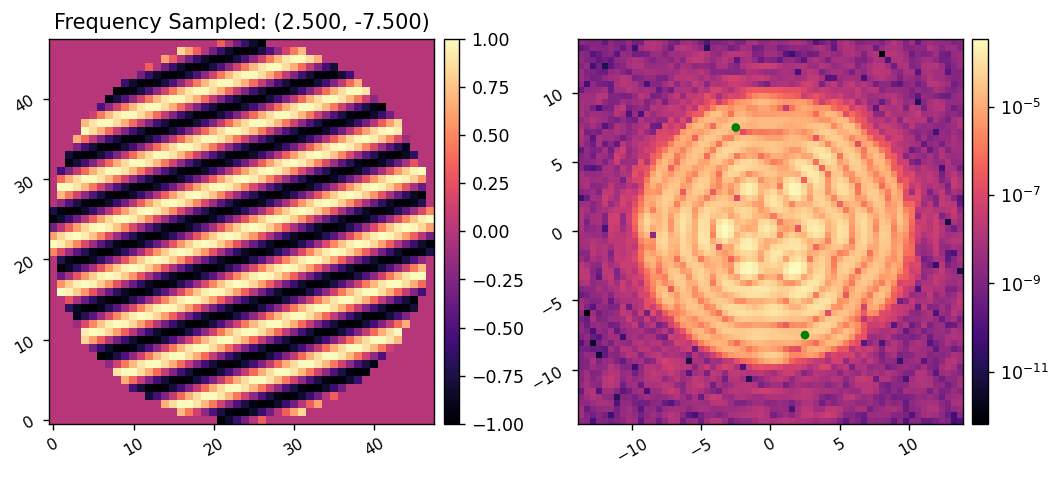

In [47]:
for i in range(fourier_modes.shape[0]//2):
    try:
        wfsc.imshow2(fourier_modes[i].reshape(Nact,Nact), ref_im, 
                       'Frequency Sampled: ({:.3f}, {:.3f})'.format(fs[i][0], fs[i][1]),
                       lognorm2=True,
                       pxscl2=c.psf_pixelscale_lamD, 
                       patches2=[Circle(fs[i], 0.25, fill=True, color='g'),
                                 Circle(-fs[i], 0.25, fill=True, color='g')])
        clear_output(wait=True)
        time.sleep(0.25)
    except KeyboardInterrupt:
        break

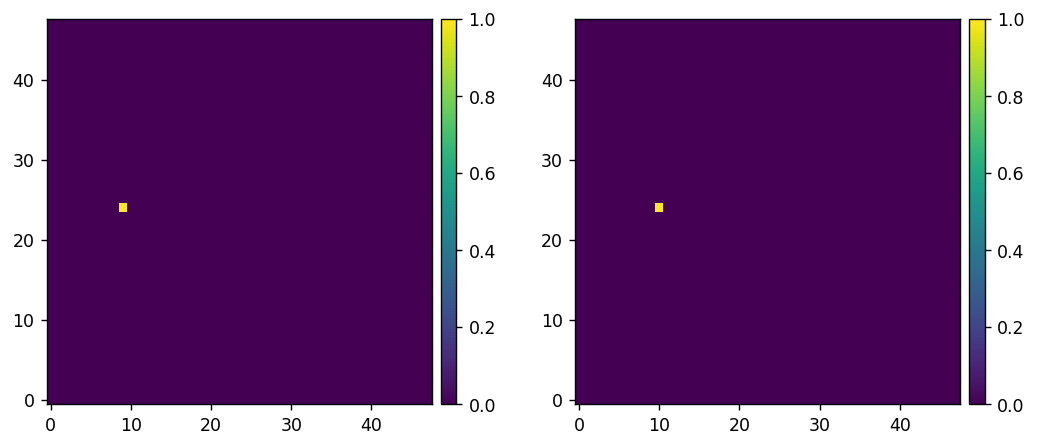

In [48]:
reload(wfsc.utils)
# probe_modes_1 = wfsc.utils.create_fourier_probes(fourier_modes, plot=True)
# probe = 1/np.sqrt(2) * np.sum((fourier_modes[:nf] + fourier_modes[nf:]), axis=0).reshape(Nact,Nact)
# probe /= probe.max()
# wfsc.imshow1(probe)

# probe_modes = np.array([probe_modes_1[0], probe, probe_modes_1[1]])
# wfsc.imshow3(probe_modes[0], probe_modes[1], probe_modes[2])

probe_modes = wfsc.utils.create_probe_poke_modes(Nact, 
                                                 poke_indices=[(Nact//5, Nact//2), (Nact//5+1, Nact//2)], 
                                                 plot=True)

# probe_modes = wfsc.utils.create_probe_poke_modes(Nact, 
#                                                  poke_indices=[(Nact//4, Nact//4), 
#                                                                (3*Nact//4, Nact//4), 
#                                                                (Nact//2, 3*Nact//4)], 
#                                                  plot=True)


# probe_modes = probe_modes_1 + probe_modes_2

# wfsc.imshow2(probe_modes[0], probe_modes[1])

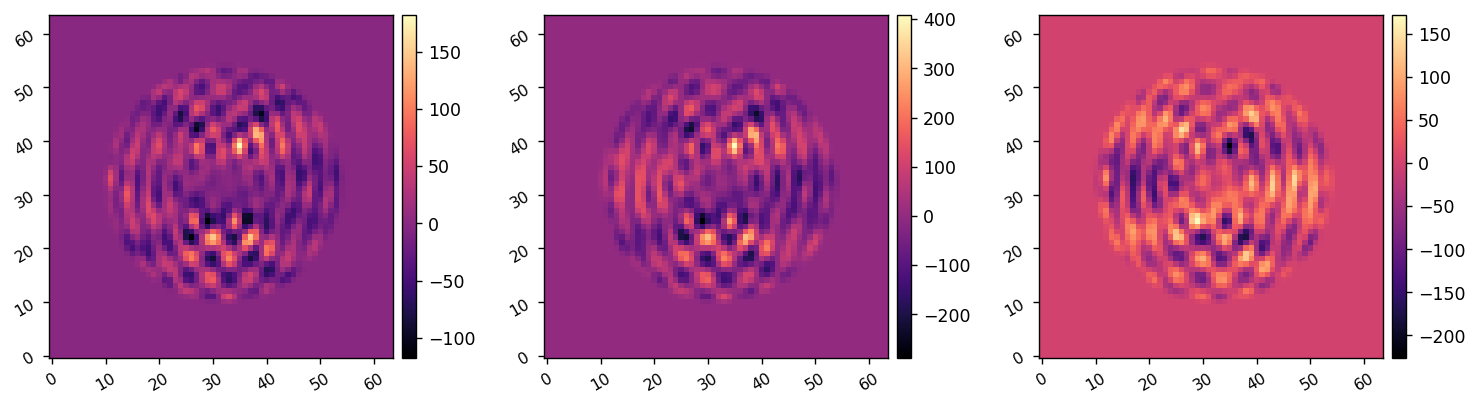

In [49]:
reload(wfsc.iefc)

probe_amp = 5e-8
calib_amp = 5e-9

# c.texp = 1

c.set_dm1(dm1_flat)
c.set_dm2(dm2_flat)

differential_images, single_images = wfsc.iefc_2dm.take_measurement(c, 
                                                                   probe_modes, probe_amp, 
                                                                   return_all=True)
ims = differential_images.reshape(2, c.npsf, c.npsf)
wfsc.imshow3(ims[0], ims[1], ims[0]-ims[1], wspace=0.35)

In [50]:
reload(wfsc.iefc_2dm)
response_matrix, response_cube = wfsc.iefc_2dm.calibrate(c, 
                                                         control_mask.ravel(),
                                                         probe_amp, probe_modes, 
                                                         calib_amp, fourier_modes, 
                                                         return_all=True)


Calibrating I-EFC...


KeyboardInterrupt: 

In [53]:
response_matrix = xp.array(fits.getdata(iefc_dir/'response-data'/'hlc_iefc_2dm_response_matrix_20230619.fits'))
response_cube = xp.array(fits.getdata(iefc_dir/'response-data'/'hlc_iefc_2dm_response_cube_20230619.fits'))

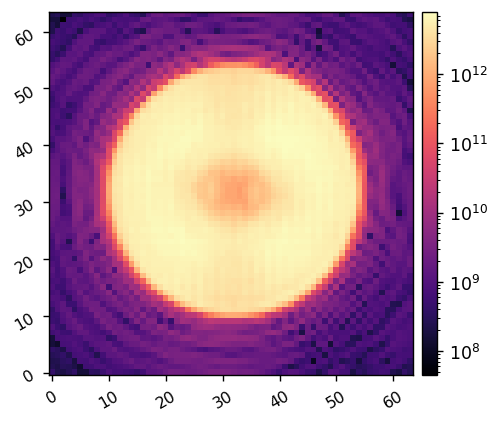

In [54]:
response_sum = xp.sum(abs(response_cube), axis=(0,1))
wfsc.imshow1(response_sum.reshape(npsf, npsf), lognorm=True)

# Run IEFC

Running I-EFC...
	Closed-loop iteration 1 / 10


(472,)

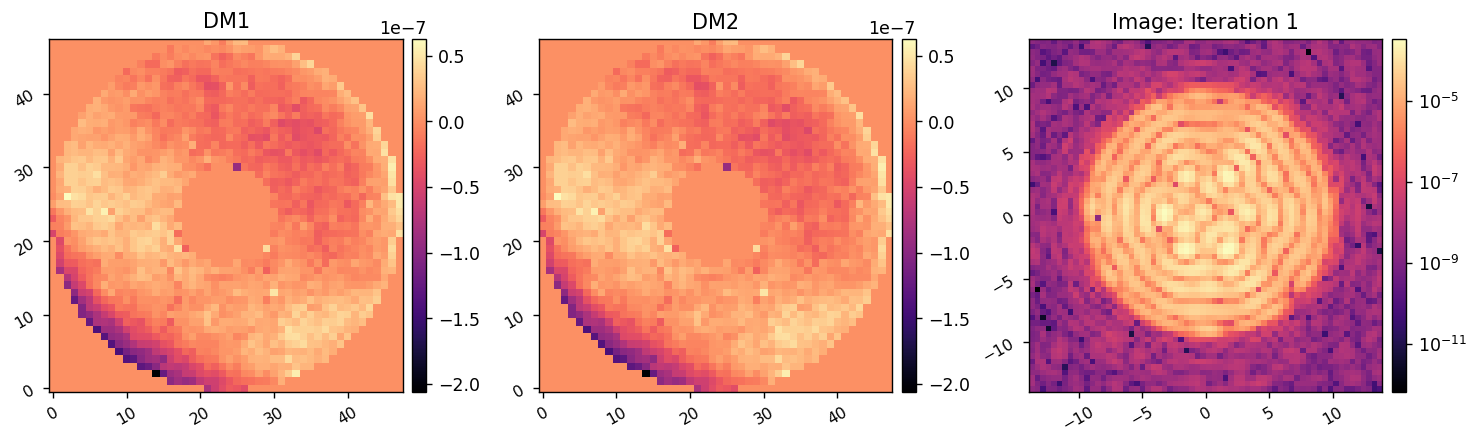

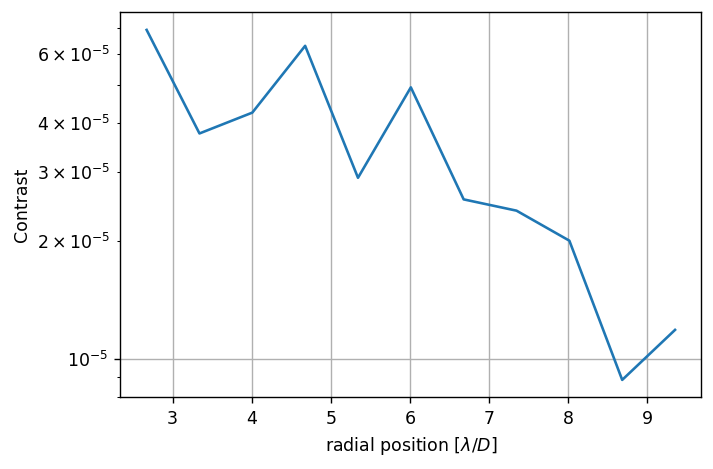

	Closed-loop iteration 2 / 10


(472,)

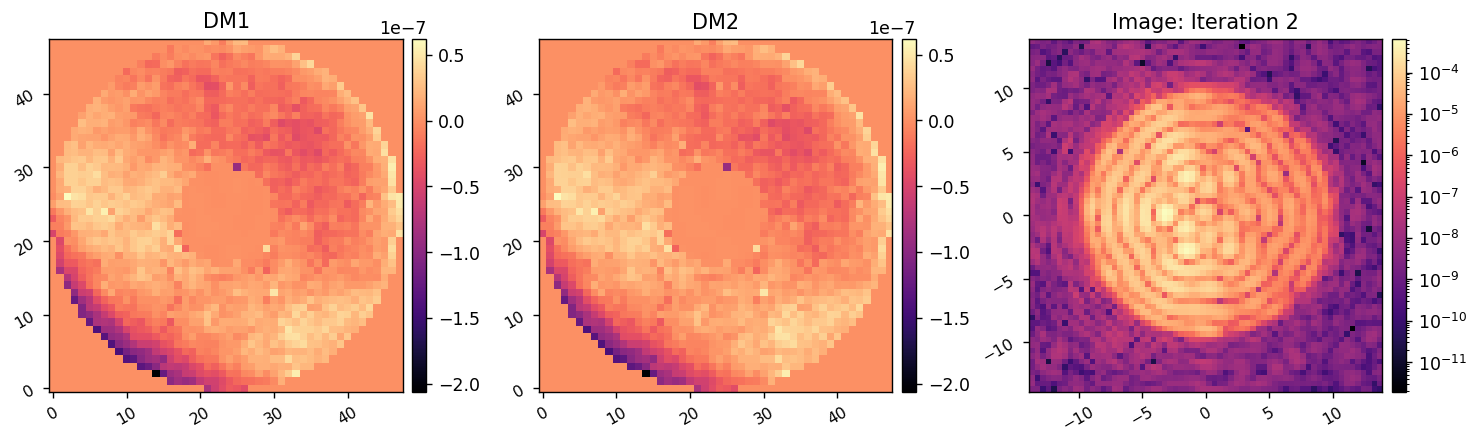

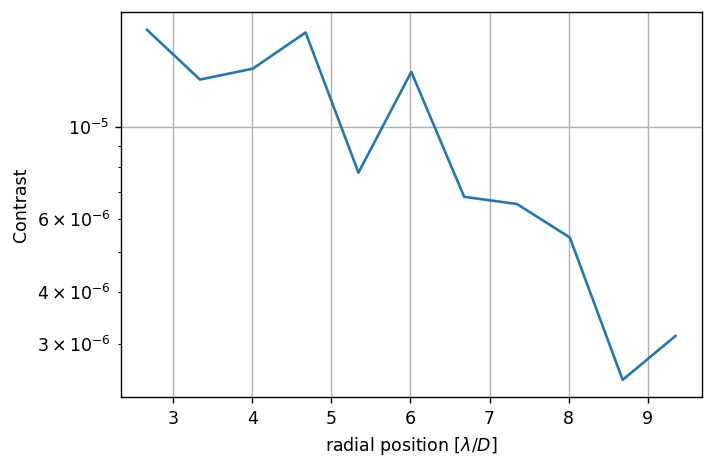

	Closed-loop iteration 3 / 10


(472,)

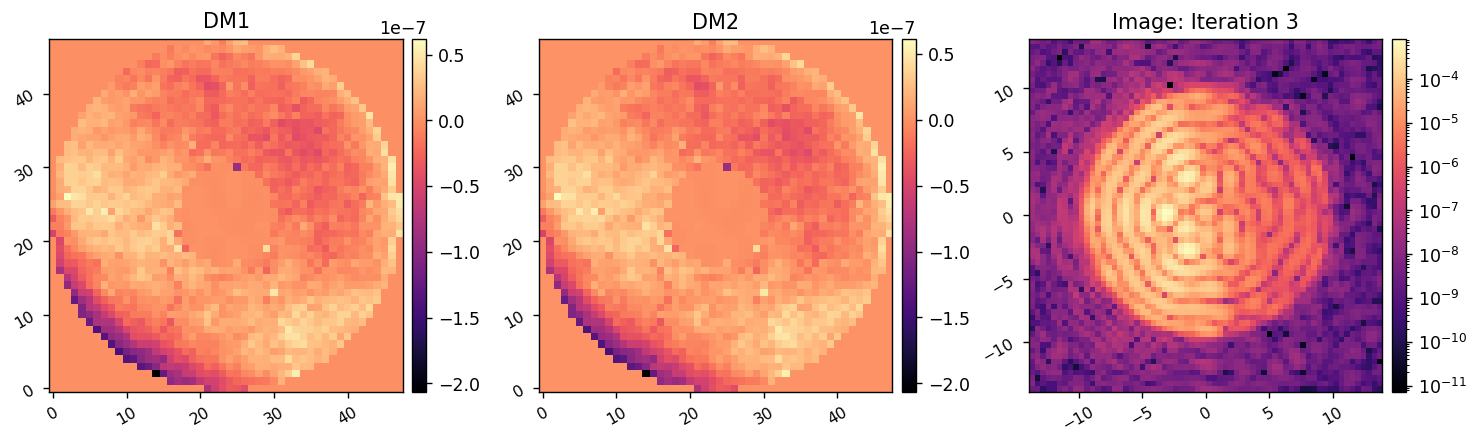

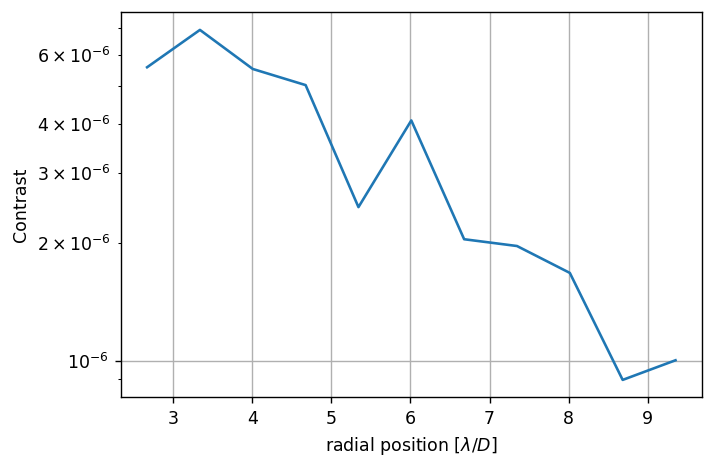

	Closed-loop iteration 4 / 10


(472,)

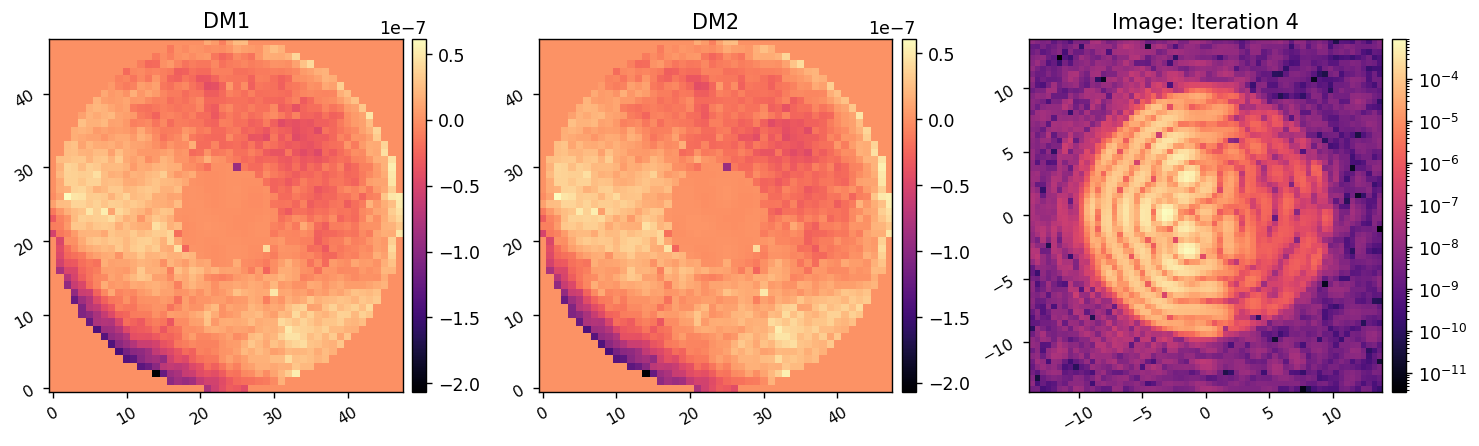

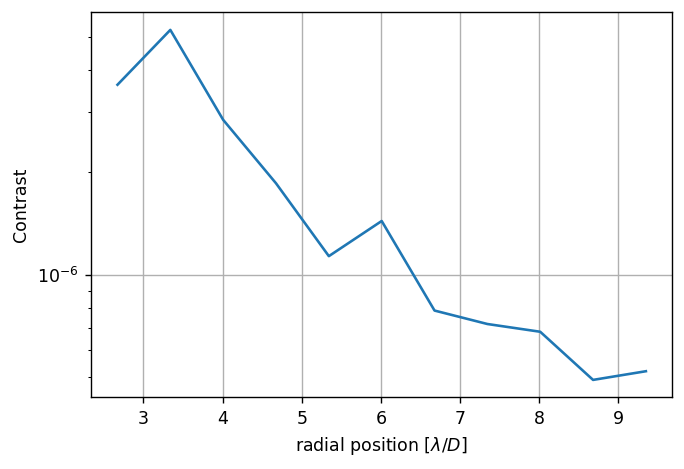

	Closed-loop iteration 5 / 10


(472,)

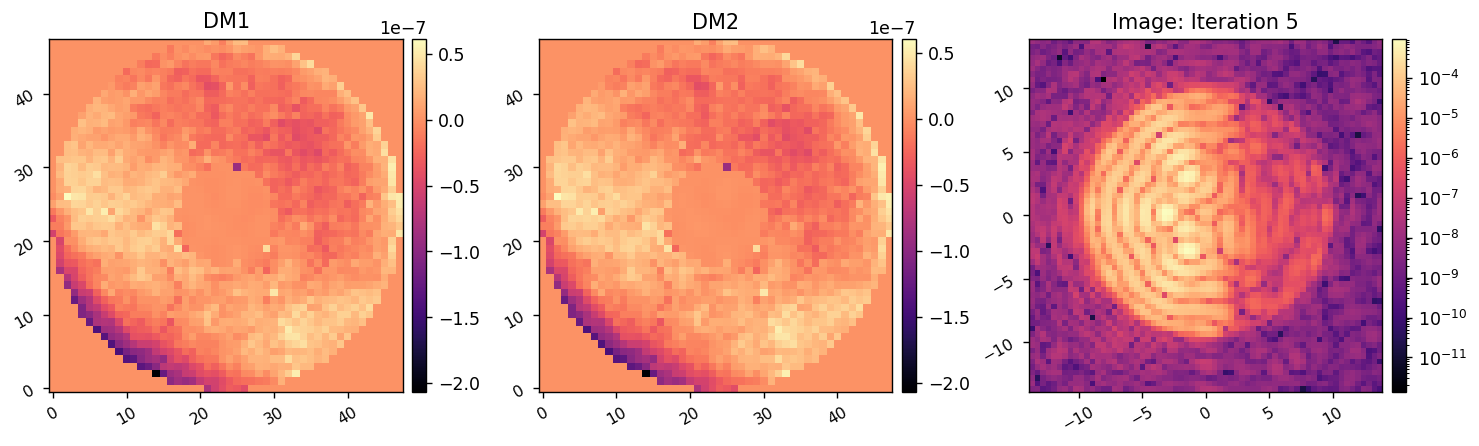

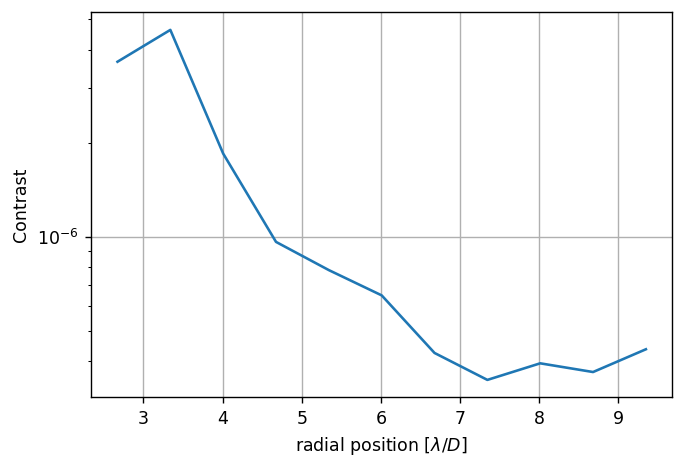

	Closed-loop iteration 6 / 10


(472,)

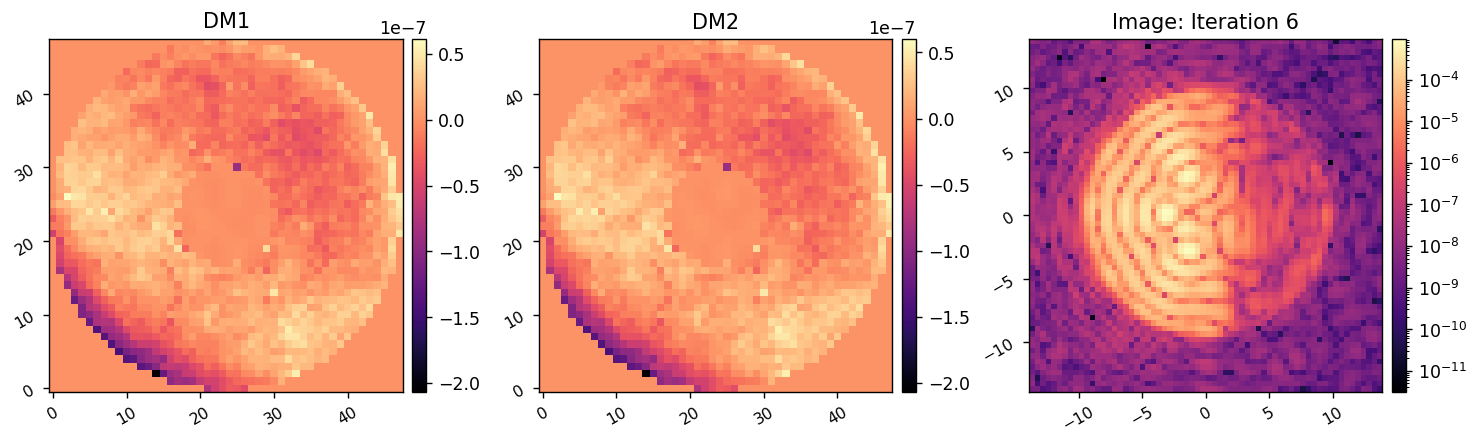

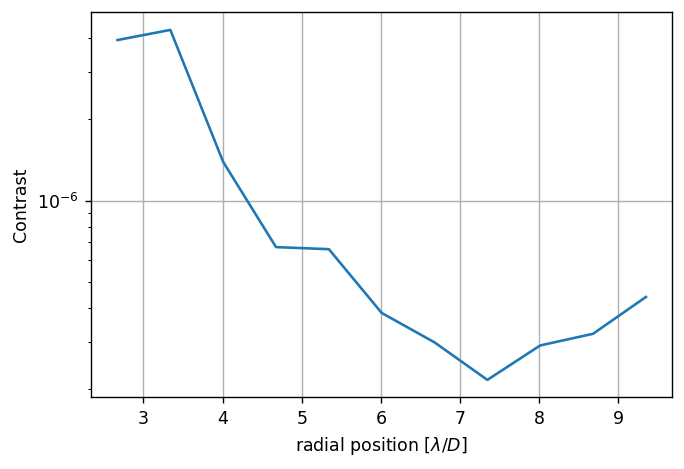

	Closed-loop iteration 7 / 10


(472,)

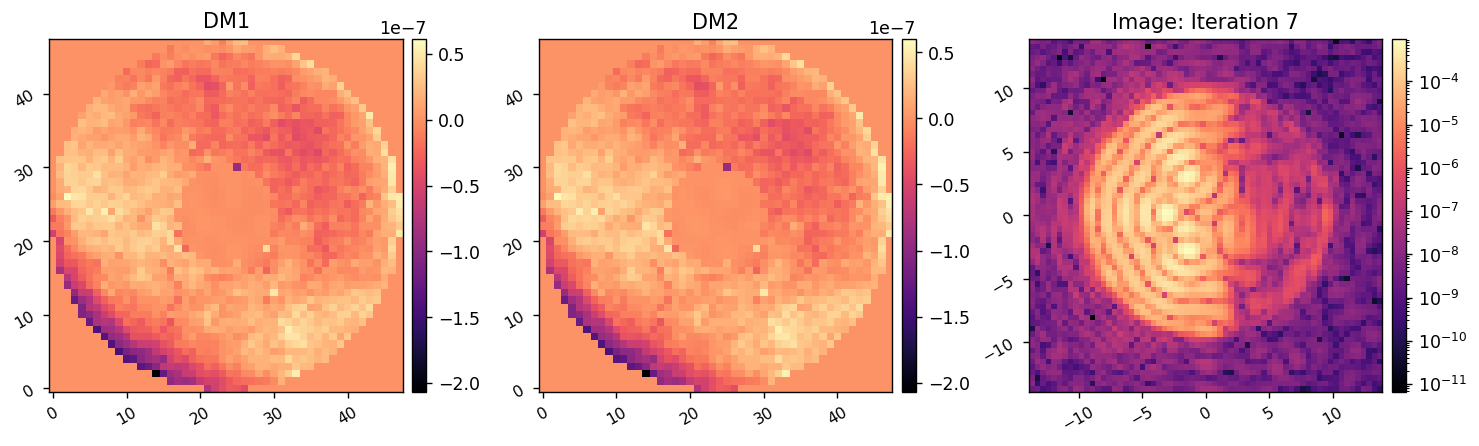

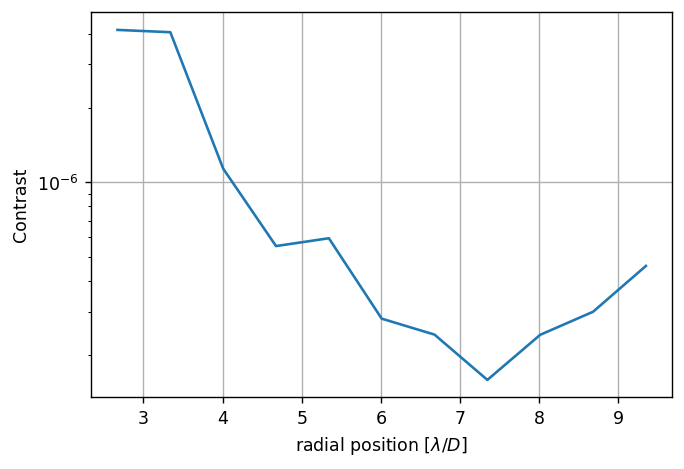

	Closed-loop iteration 8 / 10


(472,)

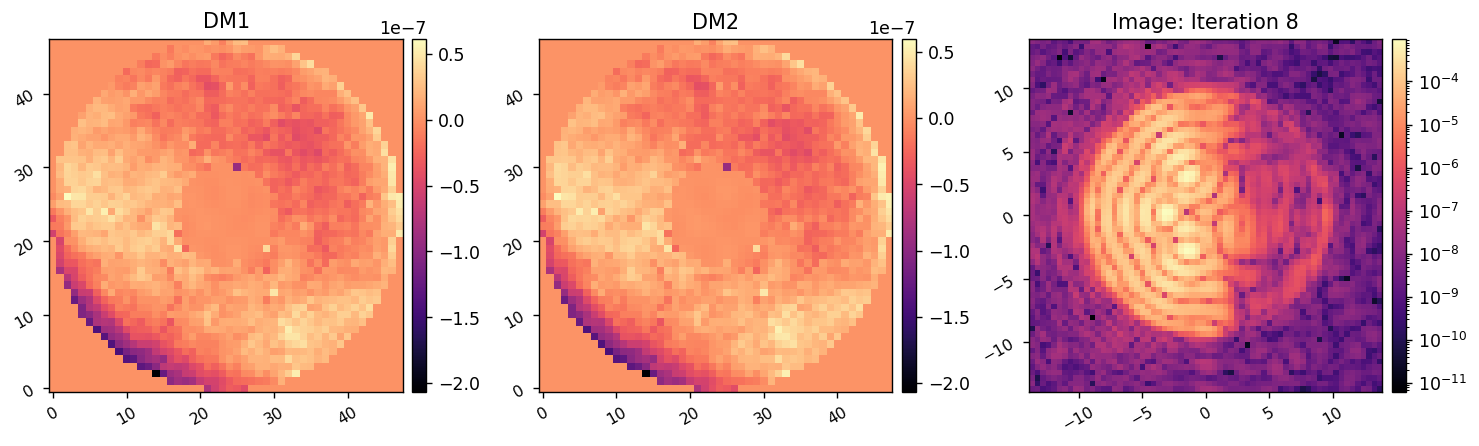

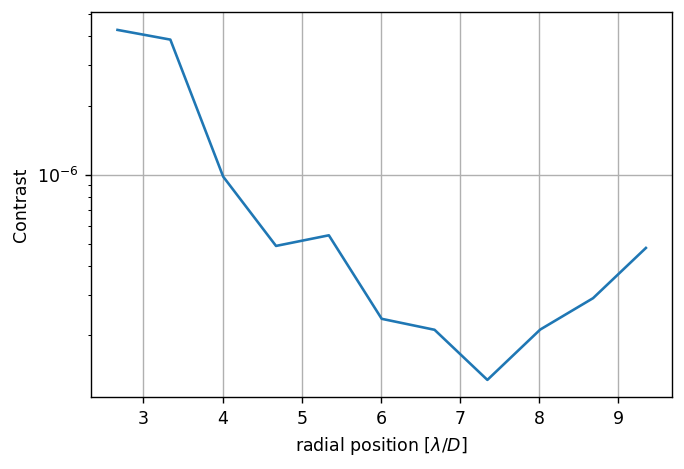

	Closed-loop iteration 9 / 10


(472,)

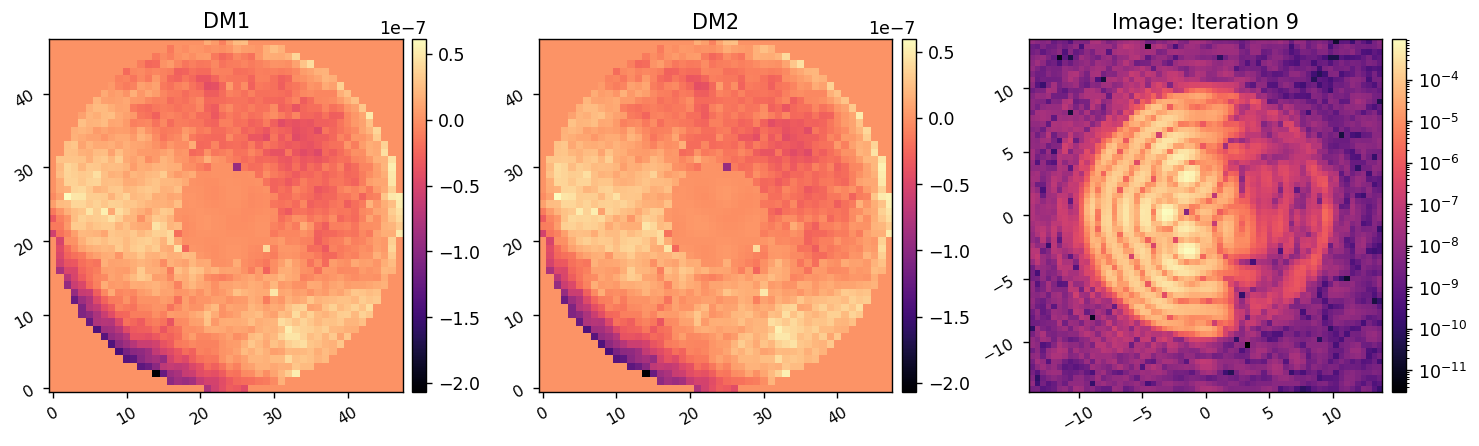

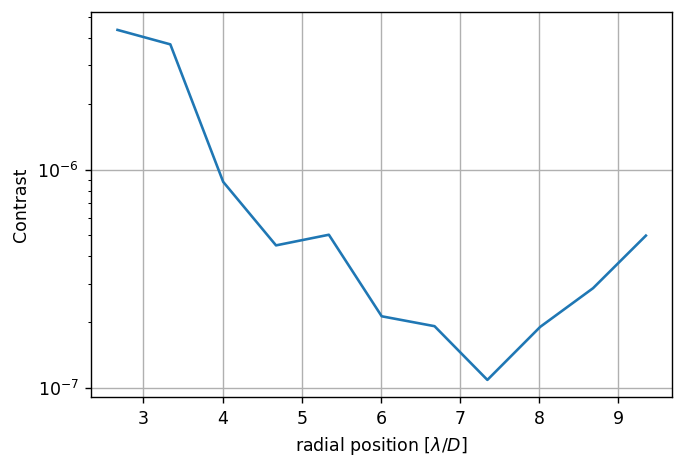

	Closed-loop iteration 10 / 10


(472,)

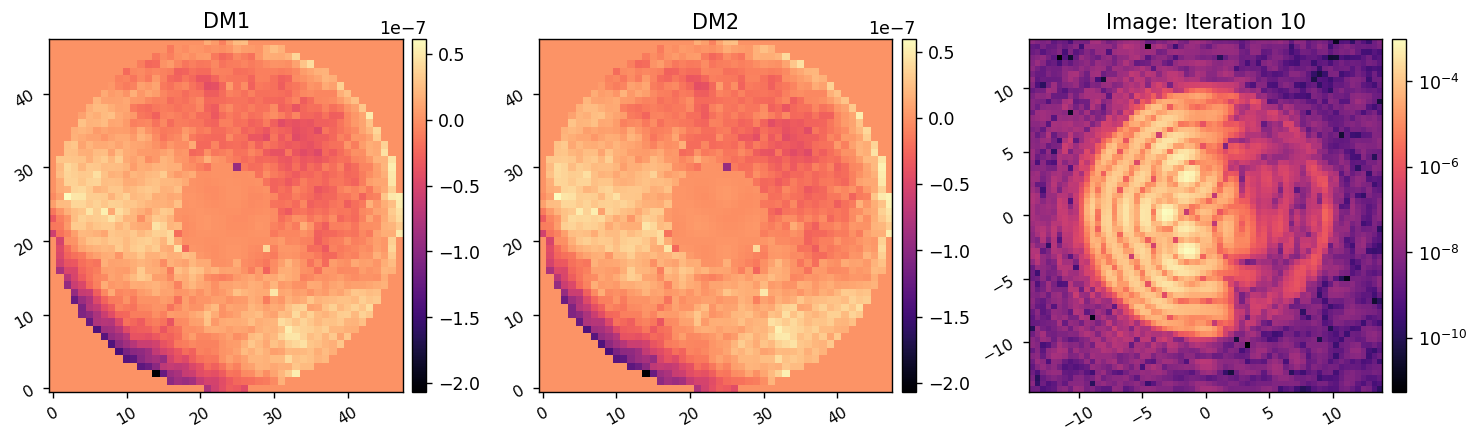

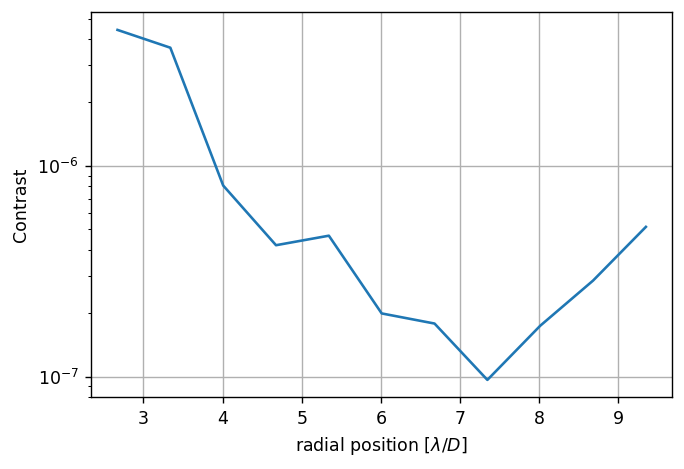

I-EFC loop completed in 24.452s.


In [56]:
reload(wfsc.iefc_2dm)
reload(wfsc.utils)

c.set_dm1(dm1_flat)
c.set_dm2(dm2_flat)

Wmatrix = np.diag(np.concatenate((weight_map[control_mask], weight_map[control_mask])))

reg_cond = 1e-2
cm_wls = wfsc.utils.WeightedLeastSquares(response_matrix, Wmatrix, rcond=reg_cond)
    
images, dm1_commands, dm2_commands = wfsc.iefc_2dm.run(c, 
                                          cm_wls,
                                          probe_modes, 
                                          probe_amp, 
                                          fourier_modes,
                                          control_mask, 
                                          num_iterations=10, 
                                          loop_gain=0.5, 
                                          leakage=0.0,
                                          plot_all=True,
                                         )

# Run iEFC with recalibrations after a given number of iterations

In [60]:
reload(wfsc.iefc_2dm)
reload(wfsc.utils)

c.set_dm1(dm1_flat)
c.set_dm2(dm2_flat)

reg_cond = 1e-2

Wmatrix = np.diag(np.concatenate((weight_map[control_mask], weight_map[control_mask])))

Ncalibs = 3
for i in range(Ncalibs):
    print('Calibrations {:d}/{:d}'.format(i+1, Ncalibs))
    response_matrix, response_cube = wfsc.iefc_2dm.calibrate(c, 
                                                             control_mask.ravel(),
                                                             probe_amp, probe_modes, 
                                                             calib_amp, fourier_modes, 
                                                             return_all=True)
    
    response_sum = xp.sum(abs(response_cube), axis=(0,1))
    wfsc.imshow1(response_sum.reshape(npsf, npsf), lognorm=True)
    
    misc.save_fits(iefc_dir/'response-data'/'hlc_iefc_2dm_response_matrix_{:d}_{:d}_20230619.fits'.format(i+1, Ncalibs), 
               wfsc.utils.ensure_np_array(response_matrix))
    misc.save_fits(iefc_dir/'response-data'/'hlc_iefc_2dm_response_cube_{:d}_{:d}_20230619.fits'.format(i+1, Ncalibs), 
                   wfsc.utils.ensure_np_array(response_cube))
    
    cm_wls = wfsc.utils.WeightedLeastSquares(response_matrix, Wmatrix, rcond=reg_conds[i][0])
    
    images, dm1_commands, dm2_commands = wfsc.iefc_2dm.run(c, 
                                              cm_wls,
                                              probe_modes, 
                                              probe_amp, 
                                              fourier_modes,
                                              control_mask, 
                                              num_iterations=reg_conds[i][1], 
                                              loop_gain=0.1, 
                                              leakage=0.0,
                                              plot_all=True,
                                             )
    misc.save_fits(iefc_dir/'images'/'hlc_iefc_2dm_images_{:d}_{:d}_20230619.fits'.format(i+1, Ncalibs), 
                   wfsc.utils.ensure_np_array(images))
    misc.save_fits(iefc_dir/'dm-commands'/'hlc_iefc_2dm_dm1_{:d}_{:d}_20230619.fits'.format(i+1, Ncalibs), 
                   wfsc.utils.ensure_np_array(dm1_commands))
    misc.save_fits(iefc_dir/'dm-commands'/'hlc_iefc_2dm_dm2_{:d}_{:d}_20230619.fits'.format(i+1, Ncalibs), 
                   wfsc.utils.ensure_np_array(dm2_commands))

Calibrations 1/3
Calibrating I-EFC...


KeyboardInterrupt: 